<a href="https://colab.research.google.com/github/vlad-uve/CAE-MNIST/blob/main/notebooks/CAE_experiment_3(batch_norm).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Autoencoder (CAE) — Experiment #3: Usage of Batch Normalization

This notebook investigates the impact of incorporating batch normalization into the CAE architecture, specifically on training dynamics and reconstruction quality.

---

## 📌 Objective

To evaluate how batch normalization affects the model's convergence behavior, loss stability, and reconstruction quality. The results are compared against the baseline model, which does not use batch normalization.

---

## 🔁 Experiment Workflow

- Clone the project and configure dependencies  
- Define a CAE variant with batch normalization layers enabled  
- Train the model over 20 epochs using the Adam optimizer  
- Analyze training and validation losses, and compare reconstruction quality with the baseline  
- Make conclusions  
- Export results to GitHub

---

## 📊 Key Findings

- Batch normalization has minimal impact on reconstruction quality, offering only slight visual improvement  
- It does not reduce model compactness or change parameter count, but adds unnecessary architectural overhead  
- Given the minor benefits, batch normalization should be excluded to keep the model efficient and lightweight  

---

## 1. 🔧 Setup

This section prepares the environment for running the experiment.

- Clone the GitHub repository  
- Import model classes and utility functions from `src/`  
- Import necessary libraries  
- Define constants

## 2. 🧠 Define Experiment Model

This section defines a single CAE variant that enables batch normalization in all convolutional layers.

- `experiment_3_model_1`: `batch_norm = True`

🟩 **Baseline model:** `batch_norm = False`
All other architectural and training parameters remain consistent with the baseline model:
- Convolutional filters: `[32, 32, 64]`
- Latent dimension: 32  
- Batch sizes: 32 (train) / 500 (validation)  
- Activation: ReLU  
- Optimizer: Adam (`lr = 1e-3`)  
- Scheduler: `ReduceLROnPlateau`
- Epochs: 20 epochs

## 3. 🏋️‍♀️ Train Experiment Model

The model is trained using the `run_model_training()` function, following the same structure and data loaders as the baseline:

- A CAE with batch normalization is initialized  
- Optimizer and scheduler are defined as in the baseline  
- The model is trained for 20 epochs  
- Training and validation losses are logged  
- The final model and its loss history are stored for analysis

## 4. 🔍 Results and Observations

### 4.1 📉 Loss Curve Analysis

- Both models (**batch_norm=True** and **batch_norm=False**) showed nearly identical training dynamics.

- Loss plateau was reached at the same time for both, with no signs of overfitting.

- Validation loss was slightly lower for the model with batch normalization suggesting marginal difference in reconstruction quality.


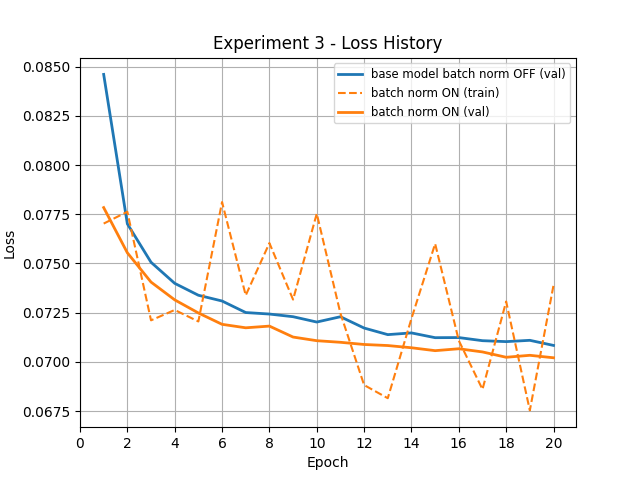

In [23]:
display(Image(filename="CAE-MNIST/outputs/experiment_3_files/experiment_3_image_loss.png"))

### 4.2 📷 Reconstruction Quality Analysis

- Reconstruction quality is nearly indistinguishable between the baseline model (with batch normalization) and the alternative; all features are well preserved.

- Upon closer inspection, **the model with batch norm OFF** yields slightly crisper digit edges, reflecting a minor but consistent advantage.

- This subtle sharpness correlates with a **slightly lower reconstruction loss** observed in the training curve




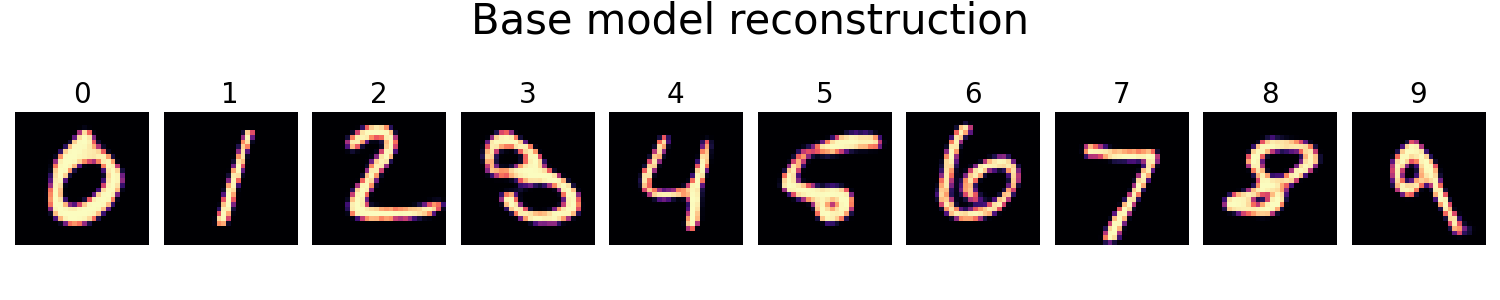

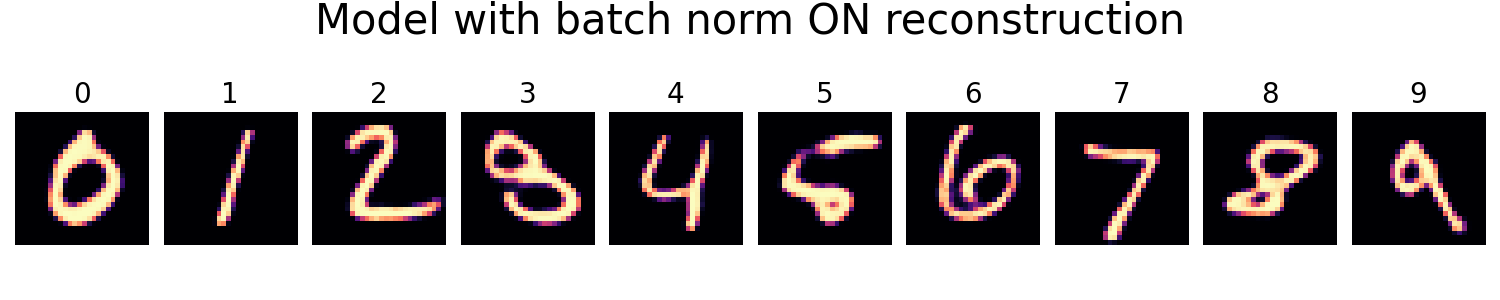

In [29]:
display_reconstruction_images(3, 1)

### 4.3 🧮 Model Complexity Analysis
Parameter count was identical for both configurations. Batch normalization did not add trainable parameters but introduced additional operations, slightly increasing runtime and architectural heaviness

- Parameters of **model with batch normaization ON**: ~137
- Parameters of **base model with batch normaization OFF**: ~137K

## 5. ✅ Conclusion

This experiment shows that **batch normalization brings only marginal gains in reconstruction quality**, offering slightly sharper outputs and a minor improvement in validation loss, while having no noticeable effect on training dynamics.

However, despite leaving parameter count unchanged, **it introduces additional operations that make the architecture heavier without improving compactness** or achieving meaningful efficiency gains.

Given the negligible performance benefit and added computational overhead, **batch normalization should be deprecated in this setup** to maintain a lighter, more streamlined autoencoder architecture.

This confirms that batch normalization layers offer little to no advantage for a low-complexity task like MNIST autoencoding, and are therefore unnecessary in this context.

# 🛠️ Notebook Workflow
The sections below contain the actual code used to define, train, and evaluate the variant CAE models for this experiment. This includes model setup, training logic, and result generation. These blocks serve as the working core of the notebook and support the summary presented above

## 1. 🔧 Setup

In [1]:
from getpass import getpass

# get repo url
token = getpass("Paste your GitHub token")
user_name = 'vlad-uve'
repo_name = 'CAE-MNIST'
repo_url = f"https://{token}@github.com/{user_name}/{repo_name}.git"

# clone the repo
!git config --global user.email "vladislav.yushkevich.uve@gmail.com"
!git config --global user.name "vlad_uve"
!git clone {repo_url}

# append system path
import sys
sys.path.append('/content/CAE-MNIST')

Paste your GitHub token··········
Cloning into 'CAE-MNIST'...
remote: Enumerating objects: 939, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 939 (delta 32), reused 18 (delta 18), pack-reused 898 (from 1)
Receiving objects: 100% (939/939), 25.32 MiB | 30.91 MiB/s, done.
Resolving deltas: 100% (525/525), done.


In [3]:
# import core model components
from src.model import AutoEncoder, Encoder, Decoder

# import training utilities
from src.train import train_model, validate_model, run_model_training

# import data loading functions
from src.data import get_train_dataloader, get_validation_dataloader

# import evaluation helpers
from src.evaluation import get_experiment_reconstructions, get_image_samples

# import plotting functions
from src.plotting import plot_digits_row, plot_experiment_reconstructions, plot_experiment_history, display_reconstruction_images

# import exporting functions
from src.export import save_experiment_files, export_experiment_files

In [4]:
# OS and file utilities
import os
import shutil

# PyTorch core modules
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Data loading and transformations
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Model summary utility
from torchsummary import summary

# Learning rate scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Plotting
import matplotlib.pyplot as plt

# Import utility to display images directly in notebook
from IPython.display import Image, display

In [5]:
# set device to GPU if available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# set random seed for reproducibility
torch.manual_seed(0)

## 2. 🧠 Define Experiment Model



In [6]:
# Load base model description
base_model_files_path = '/content/CAE-MNIST/outputs/base_model_files'
with open(os.path.join(base_model_files_path, 'base_description.txt'), 'r') as f:
    base_description = f.read()

# print baseline model description
print(base_description)

Baseline model configuration:
- Architecture: n_channels = [32, 32, 64], latent_dim = 32
- Batch normalization: False
- Activation function: ReLU
- Optimizer: Adam (lr = 1e-3)
- Scheduler: ReduceLROnPlateau (patience = 3, factor = 0.5, threshold = 1e-3)
- Training: 20 epochs
- Train batch size: 32
- Validation batch size: 500


In [7]:
# define base parameters from the description
base_n_channels=[32, 32, 64]
base_latent_dim=32
base_train_batch_size=32
base_validation_batch_size=500
base_num_epoch=20

# initialize base dataloaders
base_train_dataloader = get_train_dataloader(batch_size=base_train_batch_size, data_dir='../data')
base_validation_dataloader = get_validation_dataloader(batch_size=base_validation_batch_size, data_dir='../data')

100%|██████████| 9.91M/9.91M [00:00<00:00, 54.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.66MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.0MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 3.93MB/s]


In [8]:
# define experiment 3 description: testing latent dimension configurations
experiment_3_description = f"""
Experiment 3: effect of batch normalization
One model tested:
experiment_3_model_1: batch normalization = True
Other parameters are the same as for the base line model
"""
print(experiment_3_description.strip())

# initialize experiment lists
experiment_3_losses = []
experiment_3_models = []

Experiment 3: effect of batch normalization
One model tested:
experiment_3_model_1: batch normalization = True
Other parameters are the same as for the base line model


## 3. 🏋️‍♀️ Train Experiment Model

In [ ]:
# create model with batch normalization
model = AutoEncoder(
    n_channels=base_n_channels,
    latent_dim=base_latent_dim,
    use_batch_norm=True
).to(device)

# define optimizer and scheduler
base_optimizer = optim.Adam(model.parameters(), lr=1e-3)
base_scheduler = ReduceLROnPlateau(
    base_optimizer,
    mode='min',
    threshold=1e-3,
    patience=3,
    factor=0.5
)

# train model
model, loss_history = run_model_training(
    model=model,
    train_dataloader=base_train_dataloader,
    validation_dataloader=base_validation_dataloader,
    optimizer=base_optimizer,
    scheduler=base_scheduler,
    num_epoch=base_num_epoch,
    device=device
)

# record results
experiment_3_losses.append(loss_history)
experiment_3_models.append(model)


TRAINING IS STARTED:
Epoch  1 | Train Loss: 0.0770 | Validation Loss: 0.0778
Epoch  2 | Train Loss: 0.0776 | Validation Loss: 0.0755
Epoch  3 | Train Loss: 0.0721 | Validation Loss: 0.0741
Epoch  4 | Train Loss: 0.0726 | Validation Loss: 0.0732
Epoch  5 | Train Loss: 0.0721 | Validation Loss: 0.0725
Epoch  6 | Train Loss: 0.0781 | Validation Loss: 0.0719
Epoch  7 | Train Loss: 0.0734 | Validation Loss: 0.0717
Epoch  8 | Train Loss: 0.0760 | Validation Loss: 0.0718
Epoch  9 | Train Loss: 0.0732 | Validation Loss: 0.0713
Epoch 10 | Train Loss: 0.0775 | Validation Loss: 0.0711
Epoch 11 | Train Loss: 0.0725 | Validation Loss: 0.0710
Epoch 12 | Train Loss: 0.0688 | Validation Loss: 0.0709
Epoch 13 | Train Loss: 0.0682 | Validation Loss: 0.0708
Epoch 14 | Train Loss: 0.0722 | Validation Loss: 0.0707
Epoch 15 | Train Loss: 0.0760 | Validation Loss: 0.0706
Epoch 16 | Train Loss: 0.0711 | Validation Loss: 0.0707
Epoch 17 | Train Loss: 0.0686 | Validation Loss: 0.0705
Epoch 18 | Train Loss: 0.0

## 4. 🔍 Results and Observations

### 4.1 📉 Loss Curve Analysis

In [9]:
# import base loss
base_loss = torch.load('/content/CAE-MNIST/outputs/base_model_files/base_loss.pth')

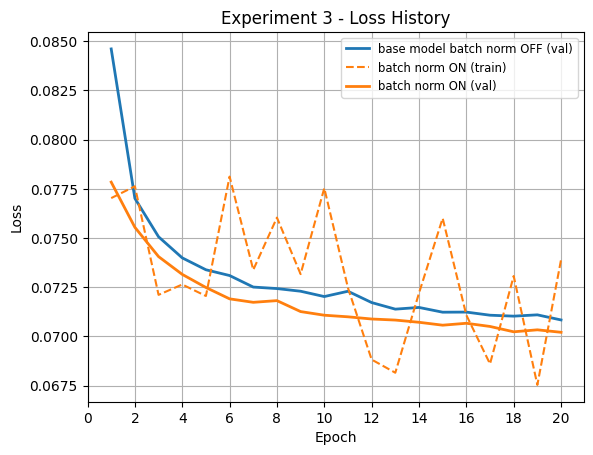

In [21]:
# plot baseeline validation loss
plot_experiment_history([base_loss], label_list=['base model batch norm OFF'])

# plot training and validation losses for experiment 3 models
plot_experiment_history(
    loss_list=experiment_3_losses,
    label_list=['batch norm ON'],
    color=plt.get_cmap('tab10').colors[1:],
    to_plot_train=True
)

# format plot
plt.xticks(range(0, base_num_epoch+1, 2))
plt.legend(fontsize='small')
plt.title('Experiment 3 - Loss History')
plt.grid()

# save plot
plt.savefig("CAE-MNIST/outputs/experiment_3_files/experiment_3_image_loss.png")
plt.show()

In [22]:
# manually add and push experiment 1 loss curve image to Git repository
!git -C /content/CAE-MNIST add outputs/experiment_3_files/experiment_3_image_loss.png
!git -C /content/CAE-MNIST commit -m "Update experiment 3 loss history curve"
!git -C /content/CAE-MNIST push origin main

[main 12eae38] Update experiment 3 loss history curve
 1 file changed, 0 insertions(+), 0 deletions(-)
 rewrite outputs/experiment_3_files/experiment_3_image_loss.png (96%)
Enumerating objects: 9, done.
Counting objects: 100% (9/9), done.
Delta compression using up to 2 threads
Compressing objects: 100% (5/5), done.
Writing objects: 100% (5/5), 50.64 KiB | 16.88 MiB/s, done.
Total 5 (delta 3), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/vlad-uve/CAE-MNIST.git
   aacb646..12eae38  main -> main


### 4.2 📷 Reconstruction Quality Analysis

In [25]:
# get sample images and labels
sample_images, sample_labels = get_image_samples(base_validation_dataloader)

# get reconstructed images from experiment 3
experiment_3_reconstructions=get_experiment_reconstructions(experiment_3_models, sample_images, device)

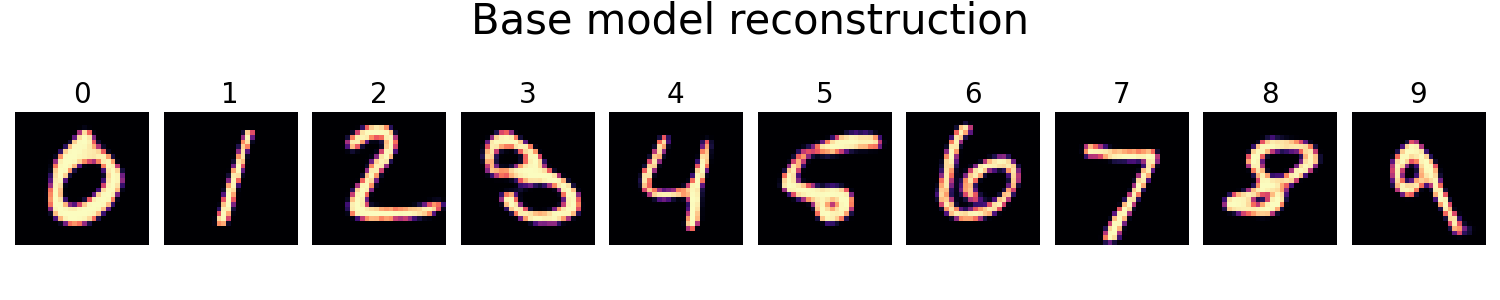

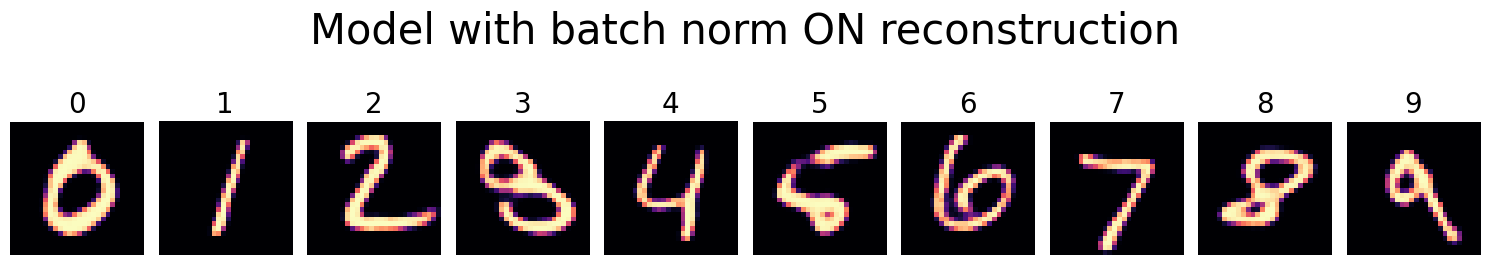

In [26]:
# display reconsructions from baseline model
display(Image(filename='/content/CAE-MNIST/outputs/base_model_files/base_image_reconstruction.png'))
print('\n')

# display reconstructions from experiment
experiment_3_reconstruction_figures = plot_experiment_reconstructions(
    experiment_3_reconstructions,
    sample_labels,
    title_list=['Model with batch norm ON']
    )

for idx, fig in enumerate(experiment_3_reconstruction_figures):
  fig.savefig(f"CAE-MNIST/outputs/experiment_3_files/experiment_3_image_reconstruction_{idx+1}.png")

In [30]:
#manually add and push experiment 3 reconstruction images to Git repository
for idx, _ in enumerate(experiment_3_reconstruction_figures):
  !git -C /content/CAE-MNIST add outputs/experiment_3_files/experiment_3_image_reconstruction_{idx+1}.png

!git -C /content/CAE-MNIST commit -m "Updated experiment 3 reconstructed digits"
!git -C /content/CAE-MNIST push origin main

On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean
Everything up-to-date


### 4.3 🧮 Model Complexity Analysis

In [28]:
# dictionary of model parameters in experiment 5
experiment_3_param_counts = {}

for i, model in enumerate(experiment_3_models):
    param_count = sum(p.numel() for p in model.parameters() if p.requires_grad)
    model_name = f"experiment_3_model_{i+1}"
    experiment_3_param_counts[model_name] = param_count

# print model paramets
print(experiment_3_param_counts)

{'experiment_3_model_1': 137825}


## 6. 📂 Export Experiment 3 Files

In [ ]:
# save all experiment 3 outputs (models, losses, reconstructions, description)
save_experiment_files(
    experiment_name="experiment_3",
    models=experiment_3_models,
    losses=experiment_3_losses,
    param_counts_dict=experiment_3_param_counts,
    reconstructions=experiment_3_reconstructions,
    description_text=experiment_3_description
)

✅ Saved experiment_3 files to: /content/CAE_experiment_3_local


In [ ]:
# export experiment 3 files to Git
export_experiment_files(
    experiment_name="experiment_3",
    model_count=len(experiment_3_models)
)

✅ Exported experiment_3 files to: outputs/experiment_3_files/


## Import Experiment 3 Files

In [11]:
# define output path for experiment 3 files
outputs_path = '/content/CAE-MNIST/outputs/experiment_3_files'

# initialize storage lists
experiment_3_models = []
experiment_3_losses = []
experiment_3_reconstructions = []

# initialize model with batch normalization enabled
model = AutoEncoder(
    n_channels=base_n_channels,
    latent_dim=base_latent_dim,
    use_batch_norm=True
).to(device)

# load model weights
model_file = 'experiment_3_model_1.pth'
model_path = os.path.join(outputs_path, model_file)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()
experiment_3_models.append(model)

# load loss history
loss_file = 'experiment_3_loss_1.pth'
loss_path = os.path.join(outputs_path, loss_file)
loss_history = torch.load(loss_path)
experiment_3_losses.append(loss_history)

# load reconstructed images
reconstructed_file = 'experiment_3_reconstruction_1.pth'
reconstructed_path = os.path.join(outputs_path, reconstructed_file)
reconstructed_images = torch.load(reconstructed_path)
experiment_3_reconstructions.append(reconstructed_images)

# Load param coun dict
param_counts_file = 'experiment_3_param_counts.pth'
param_counts_path = os.path.join(outputs_path, param_counts_file)
experiment_3_param_counts = torch.load(param_counts_path)

# load experiment description
with open(os.path.join(outputs_path, 'experiment_3_description.txt'), 'r') as f:
    experiment_3_description = f.read()

print("✅ All Experiment 3 models, losses, reconstructed images and description loaded.")

✅ All Experiment 3 models, losses, reconstructed images and description loaded.


## Re-Clone Git Repository

In [ ]:
!rm -rf /content/CAE-MNIST
#%cd /content
!git clone {repo_url}

shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
/content
Cloning into 'CAE-MNIST'...
remote: Enumerating objects: 738, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 738 (delta 51), reused 42 (delta 35), pack-reused 663 (from 2)
Receiving objects: 100% (738/738), 25.94 MiB | 29.88 MiB/s, done.
Resolving deltas: 100% (375/375), done.
